# Kpf-Bert를 이용한 뉴스기사 3줄요약 서비스  
전체기사에서 중요한 순서대로 상위 3개의 문장을 추출해서 제시하는 기사 요약 서비스이다.  
  
pytorch-lightning을 이용하여 전체프로세서를 작성하였다.  
  
BERT를 이용한 SUMMARY 관련 논문 및 nlpyang의 PreSumm 소스를 참조하였다.

In [2]:
import math
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from torch.nn.init import xavier_uniform_

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import kss

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

# GPU 사용 설정
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU to use

2022-11-08 09:07:47.938757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 09:07:48.161785: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-08 09:07:48.198283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 09:07:48.877907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 20
BATCH_SIZE = 8

# data

한국어 문서 추출요약 AI 경진대회(~ 2020.12.09)에서 사용된 Bflysoft-뉴스기사 데이터셋에 맞춰 작성을 시작하였으나,
대회가 끝난 후 데이터가 비공개로 바뀌어 구할 수 없게 되었다.

대신 AI - HUB 에서 한국어 요약 데이터셋을 공개하여 이를 활용하였다.

In [4]:
DATA_TRAIN_PATH = 'data/train_original.json'
df = pd.read_json(DATA_TRAIN_PATH)
df = df.dropna()
len(df)

193983

In [5]:
DATA_TEST_PATH = 'data/valid_original.json'
test_df = pd.read_json(DATA_TEST_PATH)
test_df = test_df.dropna()
len(test_df)

30122

In [6]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df.shape, val_df.shape, test_df.shape

((184283, 3), (9700, 3), (30122, 3))

In [7]:
# test, valid 데이터 값 조정
test_df = test_df[:10000]
val_df = val_df[:5000]

In [8]:
train_df.shape, test_df.shape, val_df.shape

((184283, 3), (10000, 3), (5000, 3))

# preprocess  
  
AI-HUB 문서요약 데이터셋 기준 전처리  
-> 기존 Bflysoft-뉴스기사 데이터셋에 맞춰 변환  
위 데이터를 구하지 못해서 다른 데이터를 변환한 것이다.  
사실 거칠 필요가 없는 과정이 되어버렸다.

In [9]:
def preprocess_data(data):
    outs = []
    for doc in data['documents']:
        line = []
        line.append(doc['media_name'])
        line.append(doc['id'])
        para = []
        for sent in doc['text']:
            for s in sent:
                para.append(s['sentence'])
        line.append(para)
        line.append(doc['abstractive'][0])
        line.append(doc['extractive'])
        a = doc['extractive']
        if a[0] == None or a[1] == None or a[2] == None:
            continue
        outs.append(line)

    outs_df = pd.DataFrame(outs)
    outs_df.columns = ['media', 'id', 'article_original', 'abstractive', 'extractive']
    return outs_df

In [10]:
train_df = preprocess_data(train_df)
train_df.head(1)

,media,id,article_original,abstractive,extractive
0,서울경제,329757316,[창업진흥원의 온라인 창업교육 플랫폼 '창업에듀'의 연간 교육수료생 수가 30만명을...,창업진흥원의 온라인강좌 창업에듀의 연간 교육수료생 수가 개편 전에는 3만 3462명...,"[0, 5, 8]"


In [11]:
i = 8
print('===== 본    문 =====')
for idx, str in enumerate(train_df['article_original'][i]):
    print(idx,':',str)
print('===== 요약정답 =====')
print(train_df['extractive'][i])
print('===== 추출본문 =====')
print('1 :', train_df['article_original'][i][train_df['extractive'][i][0]])
print('2 :', train_df['article_original'][i][train_df['extractive'][i][1]])
print('3 :', train_df['article_original'][i][train_df['extractive'][i][2]])
print('===== 생성본문 =====')
print(train_df['abstractive'][i])

===== 본    문 =====
0 : 네이버는 지난 18일 오후 '클로바 AI 비즈니스 데이'(Clova AI Business Day)를 개최하고, 기업 고객들을 위한 클로바의 AI 기술과 실제 비즈니스 적용 사례를 공유했다고 20일 밝혔다.
1 : 네이버 본사 그린팩토리 2층 커넥트홀에서 진행된 이날 행사에는 IT 업계(28%) 뿐만 아니라 제조업(18%), 금융업(10%) 등 다양한 산업군의 관계자들이 참석하며, B2B AI 기술에 관심을 보였다고 네이버는 설명했다.
2 : 행사 현장에서는 클로바 비즈니스를 이끌고 있는 네이버 정석근 리더가 클로바 AI 기술의 현황과 방향성에 대해 개괄하고, 뒤이은 3개 세션에서는 실제 비즈니스에 접목되고 있는 챗봇, OCR, 얼굴 인식, 클로바 AI 고객센터(Clova AI for Contact Center) 기술의 사례가 소개됐다.
3 : 정 리더는 "클로바는 챗봇, 음성 인식, 음성 합성, OCR, 이미지 검색, 얼굴 인식, 비디오 분석, 머신러닝 플랫폼, 텍스트 분석 등 총 9개의 AI 핵심 엔진을 자체 개발하고 있다"며 "이처럼 폭넓은 기술 라인업과 방대한 데이터를 기반으로, 고객사의 도메인에 최적화된 통합 솔루션을 제공할 수 있는 것이 클로바만의 경쟁력"이라고 강조했다.
4 : 이어 RPA(로봇프로세스자동화) 업체 유아이패스(UiPath)가 자사 RPA와 클로바 챗봇, OCR을 연동시킨 경험을 공유했다.
5 : 클로바 OCR API를 통해 사업자등록증에서 정보를 추출, 국세청 및 공정위 홈페이지에서 정상적인 사업자인지 검증한 후, 처리된 내용을 폼에 자동으로 입력하는 절차를 시연했다.
6 : 세 번째 세션에서 소개된 클로바의 얼굴인식 기술은 딥러닝을 활용해 99.98%의 정확도를 구현하면서도 모바일에 적용할 수 있을 정도로 경량화한 것이 특징이다.
7 : 얼굴 사진을 한 장만 등록해도 인식하기 때문에 사용도 쉽다.
8 : 김진중 네이버 리더는 "사용자와 사업자 모두에게 쉽고(easy), 빠르고(fast), 안

In [12]:
test_df = preprocess_data(test_df)
test_df.head(1)

,media,id,article_original,abstractive,extractive
0,한국경제,340626877,"[[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 ""넓고, ...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...,"[0, 1, 3]"


In [13]:
val_df = preprocess_data(val_df)
val_df.head(1)

,media,id,article_original,abstractive,extractive
0,충청투데이,367709517,"[충청지방통계청 '3Q 경제동향', 전문소매점·대형마트 판매 부진, 메모리 반도체 ...",충청지방통계청 발표에 따르면 건설업 수주량은 증가했으나 소매판매부진과 수출입실적 감...,"[4, 7, 9]"


# tokenizer
kpfBERT 토크나이저를 바로 쓴다.
kpfBERT 토크나이저는 형태소와 유사하게 잘 토크나이징을 하게 설계되어 있다.

In [14]:
BERT_MODEL_NAME = 'kpfbert-base' # kpf-BERT 경로 입력
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# dataset
bert에서 여러문장을 입력하기 위해 presumm 에서 제안한 형식으로 인코딩 한다.  
  
token embedding : < CLS > 문장 < SEP > 문장 < SEP > 문장 ... 문장 < SEP >  
interval segment : 0 , 0 , 0 , 1 , 1 , 0 , 0 , ... 1 , 1  
position embedding : 1 , 1 , 1 , 1 , 1 , 1 , 1 , ... 1 , 1  
  
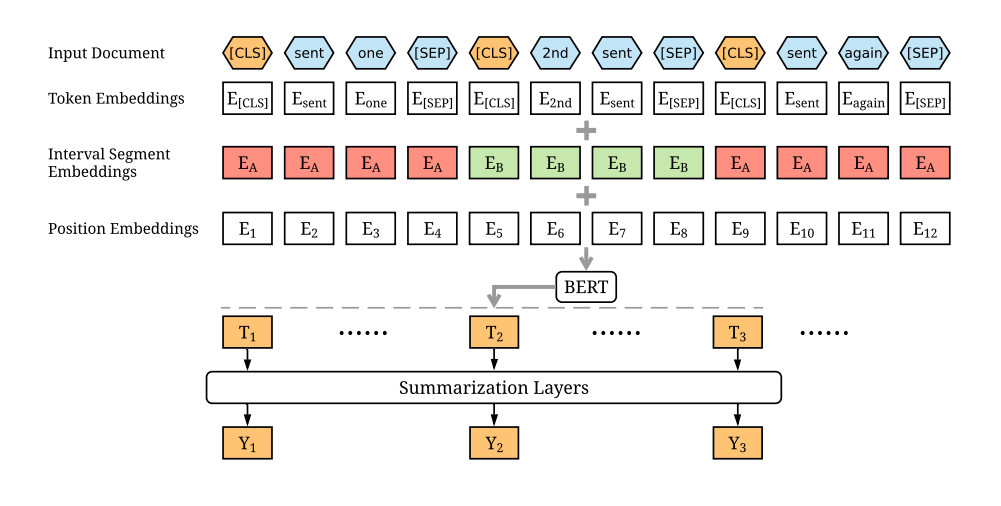

In [15]:
class SummDataset(Dataset): # 데이터셋 presumm 방식 인코딩

    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: BertTokenizer, 
        max_token_len: int = 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        tokenlist = []
        for sent in data_row.article_original:
            tokenlist.append(tokenizer(
                text = sent,
                add_special_tokens = True)) #, # Add '[CLS]' and '[SEP]'
    
        src = [] # 토크나이징 된 전체 문단
        labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
        segs = []  #각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
        clss = []  #[CLS]토큰의 포지션값을 지정

        odd = 0
        for tkns in tokenlist:
            if odd > 1 : odd = 0
            clss = clss + [len(src)]
            src = src + tkns['input_ids']
            segs = segs + [odd] * len(tkns['input_ids'])
            if tokenlist.index(tkns) in data_row.extractive :
                labels = labels + [1]
            else:
                labels = labels + [0]
            odd += 1
        
            #truncation
            if len(src) == MAX_TOKEN_COUNT:
                break
            elif len(src) > MAX_TOKEN_COUNT:
                src = src[:self.max_token_len - 1] + [src[-1]]
                segs = segs[:self.max_token_len]
                break
    
        #padding
        if len(src) < MAX_TOKEN_COUNT:
            src = src + [0]*(self.max_token_len - len(src))
            segs = segs + [0]*(self.max_token_len - len(segs))
            
        if len(clss) < MAX_TOKEN_COUNT:
            clss = clss + [-1]*(self.max_token_len - len(clss))
        if len(labels) < MAX_TOKEN_COUNT:
            labels = labels + [0]*(self.max_token_len - len(labels))

        return dict(
            src = torch.tensor(src),
            segs = torch.tensor(segs),
            clss = torch.tensor(clss),
            labels= torch.FloatTensor(labels)
        )

In [16]:
class SummDataModule(pl.LightningDataModule): # presumm 인코딩 모듈

    def __init__(self, train_df, test_df, val_df, tokenizer, batch_size=1, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = SummDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = SummDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
    
        self.val_dataset = SummDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

In [17]:
data_module = SummDataModule(
  train_df,
  test_df,  
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# MODEL
  
kpfBERT를 pretrained_bert로 불러와서 후처리 레이어를 추가하여 문장추출 모델을 만든다.

In [18]:
class PositionalEncoding(nn.Module): # positional embedding

    def __init__(self, dropout, dim, max_len=5000):
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) *
                              -(math.log(10000.0) / dim)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)
        self.dim = dim

    def forward(self, emb, step=None):
        emb = emb * math.sqrt(self.dim)
        if (step):
            emb = emb + self.pe[:, step][:, None, :]

        else:
            emb = emb + self.pe[:, :emb.size(1)]
        emb = self.dropout(emb)
        return emb

    def get_emb(self, emb):
        return self.pe[:, :emb.size(1)]

In [19]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout):
        super(TransformerEncoderLayer, self).__init__()

        self.self_attn = MultiHeadedAttention(
            heads, d_model, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, iter, query, inputs, mask):
        if (iter != 0):
            input_norm = self.layer_norm(inputs)
        else:
            input_norm = inputs

        mask = mask.unsqueeze(1)
        context = self.self_attn(input_norm, input_norm, input_norm,
                                 mask=mask)
        out = self.dropout(context) + inputs
        return self.feed_forward(out)

In [20]:
class ExtTransformerEncoder(nn.Module):
    def __init__(self, hidden_size=768, d_ff=2048, heads=8, dropout=0.2, num_inter_layers=2):
        super(ExtTransformerEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_inter_layers = num_inter_layers
        self.pos_emb = PositionalEncoding(dropout, hidden_size)
        self.transformer_inter = nn.ModuleList(
            [TransformerEncoderLayer(hidden_size, heads, d_ff, dropout)
            for _ in range(num_inter_layers)])
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.wo = nn.Linear(hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, top_vecs, mask):
        """ See :obj:`EncoderBase.forward()`"""

        batch_size, n_sents = top_vecs.size(0), top_vecs.size(1)
        pos_emb = self.pos_emb.pe[:, :n_sents]
        x = top_vecs * mask[:, :, None].float()
        x = x + pos_emb

        for i in range(self.num_inter_layers):
            x = self.transformer_inter[i](i, x, x, ~mask) 

        x = self.layer_norm(x)
        sent_scores = self.sigmoid(self.wo(x))
        sent_scores = sent_scores.squeeze(-1) * mask.float()

        return sent_scores

In [21]:
class PositionwiseFeedForward(nn.Module):
    """ A two-layer Feed-Forward-Network with residual layer norm.

    Args:
        d_model (int): the size of input for the first-layer of the FFN.
        d_ff (int): the hidden layer size of the second-layer
            of the FNN.
        dropout (float): dropout probability in :math:`[0, 1)`.
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def gelu(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


    def forward(self, x):
        inter = self.dropout_1(self.gelu(self.w_1(self.layer_norm(x))))
        output = self.dropout_2(self.w_2(inter))
        return output + x

In [22]:
class MultiHeadedAttention(nn.Module):
    """
    Multi-Head Attention module from
    "Attention is All You Need"
    :cite:`DBLP:journals/corr/VaswaniSPUJGKP17`.

    Similar to standard `dot` attention but uses
    multiple attention distributions simulataneously
    to select relevant items.

    .. mermaid::

       graph BT
          A[key]
          B[value]
          C[query]
          O[output]
          subgraph Attn
            D[Attn 1]
            E[Attn 2]
            F[Attn N]
          end
          A --> D
          C --> D
          A --> E
          C --> E
          A --> F
          C --> F
          D --> O
          E --> O
          F --> O
          B --> O

    Also includes several additional tricks.

    Args:
       head_count (int): number of parallel heads
       model_dim (int): the dimension of keys/values/queries,
           must be divisible by head_count
       dropout (float): dropout parameter
    """

    def __init__(self, head_count, model_dim, dropout=0.1, use_final_linear=True):
        assert model_dim % head_count == 0
        self.dim_per_head = model_dim // head_count
        self.model_dim = model_dim

        super(MultiHeadedAttention, self).__init__()
        self.head_count = head_count

        self.linear_keys = nn.Linear(model_dim,
                                     head_count * self.dim_per_head)
        self.linear_values = nn.Linear(model_dim,
                                       head_count * self.dim_per_head)
        self.linear_query = nn.Linear(model_dim,
                                      head_count * self.dim_per_head)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.use_final_linear = use_final_linear
        if (self.use_final_linear):
            self.final_linear = nn.Linear(model_dim, model_dim)

    def forward(self, key, value, query, mask=None,
                layer_cache=None, type=None, predefined_graph_1=None):
        """
        Compute the context vector and the attention vectors.

        Args:
           key (`FloatTensor`): set of `key_len`
                key vectors `[batch, key_len, dim]`
           value (`FloatTensor`): set of `key_len`
                value vectors `[batch, key_len, dim]`
           query (`FloatTensor`): set of `query_len`
                 query vectors  `[batch, query_len, dim]`
           mask: binary mask indicating which keys have
                 non-zero attention `[batch, query_len, key_len]`
        Returns:
           (`FloatTensor`, `FloatTensor`) :

           * output context vectors `[batch, query_len, dim]`
           * one of the attention vectors `[batch, query_len, key_len]`
        """

        batch_size = key.size(0)
        dim_per_head = self.dim_per_head
        head_count = self.head_count
        key_len = key.size(1)
        query_len = query.size(1)

        def shape(x):
            """  projection """
            return x.view(batch_size, -1, head_count, dim_per_head) \
                .transpose(1, 2)

        def unshape(x):
            """  compute context """
            return x.transpose(1, 2).contiguous() \
                .view(batch_size, -1, head_count * dim_per_head)

        # 1) Project key, value, and query.
        if layer_cache is not None:
            if type == "self":
                query, key, value = self.linear_query(query), \
                                    self.linear_keys(query), \
                                    self.linear_values(query)

                key = shape(key)
                value = shape(value)

                if layer_cache is not None:
                    device = key.device
                    if layer_cache["self_keys"] is not None:
                        key = torch.cat(
                            (layer_cache["self_keys"].to(device), key),
                            dim=2)
                    if layer_cache["self_values"] is not None:
                        value = torch.cat(
                            (layer_cache["self_values"].to(device), value),
                            dim=2)
                    layer_cache["self_keys"] = key
                    layer_cache["self_values"] = value
            elif type == "context":
                query = self.linear_query(query)
                if layer_cache is not None:
                    if layer_cache["memory_keys"] is None:
                        key, value = self.linear_keys(key), \
                                     self.linear_values(value)
                        key = shape(key)
                        value = shape(value)
                    else:
                        key, value = layer_cache["memory_keys"], \
                                     layer_cache["memory_values"]
                    layer_cache["memory_keys"] = key
                    layer_cache["memory_values"] = value
                else:
                    key, value = self.linear_keys(key), \
                                 self.linear_values(value)
                    key = shape(key)
                    value = shape(value)
        else:
            key = self.linear_keys(key)
            value = self.linear_values(value)
            query = self.linear_query(query)
            key = shape(key)
            value = shape(value)

        query = shape(query)

        key_len = key.size(2)
        query_len = query.size(2)

        # 2) Calculate and scale scores.
        query = query / math.sqrt(dim_per_head)
        scores = torch.matmul(query, key.transpose(2, 3))

        if mask is not None:
            mask = mask.unsqueeze(1).expand_as(scores)
            scores = scores.masked_fill(mask, -1e18) # how can i fix it to use fp16...

        # 3) Apply attention dropout and compute context vectors.

        attn = self.softmax(scores)

        if (not predefined_graph_1 is None):
            attn_masked = attn[:, -1] * predefined_graph_1
            attn_masked = attn_masked / (torch.sum(attn_masked, 2).unsqueeze(2) + 1e-9)

            attn = torch.cat([attn[:, :-1], attn_masked.unsqueeze(1)], 1)

        drop_attn = self.dropout(attn)
        if (self.use_final_linear):
            context = unshape(torch.matmul(drop_attn, value))
            output = self.final_linear(context)
            return output
        else:
            context = torch.matmul(drop_attn, value)
            return context


In [23]:
class Summarizer(pl.LightningModule): # 요약 모델

    def __init__(self, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.max_pos = 512
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, add_pooling_layer=False)
        self.ext_layer = ExtTransformerEncoder()
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss = nn.BCELoss(reduction='none')
    
        for p in self.ext_layer.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

    def forward(self, src, segs, clss, labels=None): #, input_ids, attention_mask, labels=None):

        # torch 버전에 따라 처리 다름
        mask_src = ~(src == 0) # 1 - (src == 0)
        mask_cls = ~(clss == -1) # 1 - (clss == -1)

        top_vec = self.bert(src, token_type_ids=segs, attention_mask=mask_src)
        top_vec = top_vec.last_hidden_state
        
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]
        sents_vec = sents_vec * mask_cls[:, :, None].float()

        sent_scores = self.ext_layer(sents_vec, mask_cls).squeeze(-1)
        
        loss = 0
        if labels is not None:
            loss = self.loss(sent_scores, labels)
            
            loss = (loss * mask_cls.float()).sum() / len(labels)
        
        return loss, sent_scores
    
    def step(self, batch):

        src = batch['src']
        if len(batch['labels']) > 0 :
            labels = batch['labels']
        else:
            labels = None
        segs = batch['segs']
        clss = batch['clss']
        
        loss, sent_scores = self(src, segs, clss, labels)    
        
        return loss, sent_scores, labels

    def training_step(self, batch, batch_idx):

        loss, sent_scores, labels = self.step(batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def validation_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def test_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def acc_loss(self, outputs):
        total_loss = 0
        hit_cnt = 0
        for outp in outputs:
            labels = outp['labels'].cpu()
            predictions, idxs = outp['predictions'].cpu().sort()
            loss = outp['loss'].cpu()
            for label, idx in zip(labels, idxs):
                for i in range(1,3):
                    if label[idx[-i-1]] == 1 : 
                        hit_cnt += 1

            total_loss += loss
            
        avg_loss = total_loss / len(outputs)
        acc = hit_cnt / (3*len(outputs)*len(labels))
        
        return acc, avg_loss
        
    def training_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('acc:', acc, 'avg_loss:', avg_loss)
        
        self.log('avg_train_loss', avg_loss, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('val_acc:', acc, 'avg_val_loss:', avg_loss)
        
        self.log('avg_val_loss', avg_loss, prog_bar=True, logger=True)

    def test_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('test_acc:', acc, 'avg_test_loss:', avg_loss)
        
        self.log('avg_test_loss', avg_loss, prog_bar=True, logger=True)

        return
        
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr=2e-5)

        steps_per_epoch=len(train_df) // BATCH_SIZE
        total_training_steps = steps_per_epoch * N_EPOCHS
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=steps_per_epoch,
            num_training_steps=total_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [24]:
model = Summarizer()

Some weights of the model checkpoint at /home/user/test/kpfbert were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# training

In [25]:
#windows
# !rmdir /s /q lightning_logs
# !rmdir /s /q  checkpoints

#linux
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [26]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 14915), started 5 days, 15:53:14 ago. (Use '!kill 14915' to kill it.)

In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="avg_val_loss",
    mode="min"
)

In [28]:
logger = TensorBoardLogger("lightning_logs", name="kpfBERT_Summary")

In [29]:
early_stopping_callback = EarlyStopping(monitor='avg_val_loss', patience=10)

In [30]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
#     precision=16, #소스 수정 또는 패키지 재설치 필요... 런타임 에러.
    progress_bar_refresh_rate=30
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [31]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
INFO:pytorch_lightning.core.lightning:
  | Name      | Type                  | Params
----------------------------------------------------
0 | bert      | BertModel             | 113 M 
1 | ext_layer | ExtTransformerEncoder | 11.0 M
2 | loss      | BCELoss               | 0     
----------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
497.868   Total estimated model params size (MB)
/home/user/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

val_acc: 0.1875 avg_val_loss: tensor(19.2720)


/home/user/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

acc: 0.4134515798939502 avg_loss: tensor(4.4873)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 23034: avg_val_loss reached 4.36521 (best 4.36521), saving model to "/home/user/test/kpfbertsum/checkpoints/best-checkpoint.ckpt" as top 1


val_acc: 0.4153904761904762 avg_val_loss: tensor(4.3652)
acc: 0.43493028207593 avg_loss: tensor(4.0434)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 46069: avg_val_loss reached 4.27965 (best 4.27965), saving model to "/home/user/test/kpfbertsum/checkpoints/best-checkpoint.ckpt" as top 1


val_acc: 0.41878095238095236 avg_val_loss: tensor(4.2796)
acc: 0.45443062833989684 avg_loss: tensor(3.7640)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 2, step 69104: avg_val_loss was not in top 1


val_acc: 0.4120761904761905 avg_val_loss: tensor(4.4006)
acc: 0.4888999142092261 avg_loss: tensor(3.3215)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 3, step 92139: avg_val_loss was not in top 1


val_acc: 0.40064761904761903 avg_val_loss: tensor(4.6802)
acc: 0.5331348775672631 avg_loss: tensor(2.7784)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 4, step 115174: avg_val_loss was not in top 1


val_acc: 0.38403809523809523 avg_val_loss: tensor(5.3129)
acc: 0.5748312609176512 avg_loss: tensor(2.2510)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 5, step 138209: avg_val_loss was not in top 1


val_acc: 0.3881904761904762 avg_val_loss: tensor(5.9017)
acc: 0.6080974087051795 avg_loss: tensor(1.8106)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 6, step 161244: avg_val_loss was not in top 1


val_acc: 0.3780952380952381 avg_val_loss: tensor(6.4637)
acc: 0.6347380280525494 avg_loss: tensor(1.4490)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 7, step 184279: avg_val_loss was not in top 1


val_acc: 0.3757714285714286 avg_val_loss: tensor(7.7363)
acc: 0.6539076147063991 avg_loss: tensor(1.1704)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 8, step 207314: avg_val_loss was not in top 1


val_acc: 0.3768 avg_val_loss: tensor(8.1935)
acc: 0.668888957797141 avg_loss: tensor(0.9508)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 9, step 230349: avg_val_loss was not in top 1


val_acc: 0.3817904761904762 avg_val_loss: tensor(9.3289)
acc: 0.6806474619368043 avg_loss: tensor(0.7774)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 10, step 253384: avg_val_loss was not in top 1


val_acc: 0.37607619047619045 avg_val_loss: tensor(9.1388)
acc: 0.6893898518817121 avg_loss: tensor(0.6377)


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 11, step 276419: avg_val_loss was not in top 1


val_acc: 0.3760380952380952 avg_val_loss: tensor(9.9560)


1

In [32]:
trainer.test(model)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/user/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

test_acc: 0.3518 avg_test_loss: tensor(9.4096)
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': 9.40964412689209, 'test_loss': 9.409642219543457}
--------------------------------------------------------------------------------


[{'test_loss': 9.409642219543457, 'avg_test_loss': 9.40964412689209}]

# predictions

In [33]:
trained_model = Summarizer.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at /home/user/test/kpfbert were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def data_process(text):
    # 문장 분리 하고,
    sents = kss.split_sentences(text)
    
    #데이터 가공하고,
    tokenlist = []
    for sent in sents:
        tokenlist.append(tokenizer(
            text = sent,
            add_special_tokens = True)) #, # Add '[CLS]' and '[SEP]'

    src = [] # 토크나이징 된 전체 문단
    labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
    segs = []  #각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
    clss = []  #[CLS]토큰의 포지션값을 지정

    odd = 0

    for tkns in tokenlist:

        if odd > 1 : odd = 0
        clss = clss + [len(src)]
        src = src + tkns['input_ids']
        segs = segs + [odd] * len(tkns['input_ids'])
        odd += 1

        #truncation
        if len(src) == MAX_TOKEN_COUNT:
            break
        elif len(src) > MAX_TOKEN_COUNT:
            src = src[:MAX_TOKEN_COUNT - 1] + [src[-1]]
            segs = segs[:MAX_TOKEN_COUNT]
            break

    #padding
    if len(src) < MAX_TOKEN_COUNT:
        src = src + [0]*(MAX_TOKEN_COUNT - len(src))
        segs = segs + [0]*(MAX_TOKEN_COUNT - len(segs))

    if len(clss) < MAX_TOKEN_COUNT:
        clss = clss + [-1]*(MAX_TOKEN_COUNT - len(clss))

    return dict(
        sents = sents, #정답 출력을 위해...
        src = torch.tensor(src),
        segs = torch.tensor(segs),
        clss = torch.tensor(clss),
    )

In [35]:
def summarize_test(text):
    data = data_process(text.replace('\n',''))
    
    #trained_model에 넣어 결과값 반환
    _, rtn = trained_model(data['src'].unsqueeze(0), data['segs'].unsqueeze(0), data['clss'].unsqueeze(0))
    rtn = rtn.squeeze()
    
    # 예측 결과값을 받기 위한 프로세스
    rtn_sort, idx = rtn.sort(descending = True)
    
    rtn_sort = rtn_sort.tolist()
    idx = idx.tolist()

    end_idx = rtn_sort.index(0)

    rtn_sort = rtn_sort[:end_idx]
    idx = idx[:end_idx]
    
    if len(idx) > 3:
        rslt = idx[:3]
    else:
        rslt = idx
        
    summ = []
    print(' *** 입력한 문단의 요약문은 ...')
    for i, r in enumerate(rslt):
        summ.append(data['sents'][r])
        print('[', i+1, ']', summ[i])

    return summ

In [36]:
#테스트 문장 입력
test_context = '''이재명 더불어민주당 대선후보는 26일 변호사비 대납 의혹과 관련, "내가 정말로 변호사비를 불법으로 받았으면 나를 구속하라"고 반박했다.
이 후보는 이날 오후 전남 신안군 응급의료 전용헬기 계류장에서 열린 '국민반상회' 후 기자들과 만나 한 시민단체 대표가 고액 수임료 의혹 증거라며 제시한 녹취록에 대해 "조작됐다는 증거를 갖고 있고 검찰에도 제출했다. 검찰과 수사기관들은 빨리 처리하시라"며 이같이 말했다.
앞서 이민구 깨어있는시민연대당 대표는 이 후보가 특정 변호사에게 수임료로 현금과 주식 등 20억원을 줬다는 의혹을 주장하며 녹취록을 제출한 바 있다. 이에 대해 송평수 선대위 부대변인은 "허위사실"이라며 "깨시민당 이 대표에게 제보를 했다는 시민단체 대표 이모 씨가 제3자로부터 기부금을 받아낼 목적으로 허위사실을 녹음한 후, 이 모 변호사에게까지 접근했다. 이러한 비상식적이고 악의적인 행태는 이재명 후보에 대한 정치적 타격을 가할 목적으로 치밀하게 준비한 것"이라고 반박했다.
이에 대해 이 후보는 "그것도 조직폭력배 조작에 버금가는 조작사건이라는 게 곧 드러날 것"이라며 "팩트확인을 하고 언급하면 좋겠다. 당사자도 아니고 제3자들이 자기끼리 녹음한 게 가치가 있느냐"고 반문했다.
그는 "사실이 아니면 무고하고 음해하는 사람들을 무고 혐의나 공직선거법 위반으로 빨리 처리해서 처벌하시라"며 "선거 국면에서 하루이틀도, 한두번도 아니고 '조폭이 뇌물 줬다'는 (허위사실 유포를) 왜 아직도 처리 안 하고 있느냐"고 검경에 불만을 드러냈다.
이어 "허위사실이 드러났으면 당연히 다시는 그런 일이 없게 해야 하는 것 아닌가. 이해가 안 된다"며 "선거관리, 또는 범죄를 단속하는 국가기관들이 이런 식으로 허위사실 유포나 무고 행위를 방치해 정치적 공격 수단으로 쓰게 하면 안 된다"고 했다.
이 후보는 또 자신이 구민주-동교동계와 접촉해 복당을 타진했다는 언론보도와 관련해선 "구체적으로 어떤 사람을 범주별로 나눠 무슨 계, 진영으로 말하는 것은 아니다"라며 "시점을 언젠가 정해 벌점이니, 제재니, 제한이니 다 없애고 모두가 합류할 수 있도록 할 생각"이라고 말했다.
종전에 언급했던 '대사면' 방침을 재확인한 셈이다. 그는 "민주당에 계셨던 분, 또 민주당에 있지 않았더라도 앞으로 함께할 분들에게 계속 연락을 하고 있다"며 "만나고 전화하고 힘을 합치자고 권유하고 있다"고 했다.
그는 " 현재 민주당이 이미 열린민주당과의 통합을 협의하고 있다"며 "거기에 더해서 꼭 민주계라고 말할 필요는 없고 부패사범이나 파렴치범으로 탈당하거나 또는 제명된 사람들이 아니라면, 국가의 미래를 걱정하는 민주개혁 진영의 일원이라면 가리지 말고 과거의 어떤 일이든 그러지 말고 힘을 합치자"고 강조했다.
언론보도에 따르면, 이 후보는 최근 구민주계인 정대철 전 고문과 연락을 주고 받으며 천정배, 정동영 전 의원 등 민주당을 탈당했던 옛 동교동계와 호남 인사들의 복당을 타진했다.
'''

In [37]:
rtn = summarize_test(test_context)

 *** 입력한 문단의 요약문은 ...
[ 1 ] 이재명 더불어민주당 대선후보는 26일 변호사비 대납 의혹과 관련, "내가 정말로 변호사비를 불법으로 받았으면 나를 구속하라"고 반박했다.
[ 2 ] 이 후보는 이날 오후 전남 신안군 응급의료 전용헬기 계류장에서 열린 '국민반상회' 후 기자들과 만나 한 시민단체 대표가 고액 수임료 의혹 증거라며 제시한 녹취록에 대해 "조작됐다는 증거를 갖고 있고 검찰에도 제출했다.
[ 3 ] 앞서 이민구 깨어있는시민연대당 대표는 이 후보가 특정 변호사에게 수임료로 현금과 주식 등 20억원을 줬다는 의혹을 주장하며 녹취록을 제출한 바 있다.
